In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 10. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 10. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies.shape 

(21601,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies, dtype=bool)
for i in range(1, 40): 
    mask_idx = np.where(np.abs(data_frequencies - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequencies = data_frequencies[mask]

# remove the frequencies below Taiji sensitive band 
mask = np.where(data_frequencies > 1e-5)[0]
data_frequencies = data_frequencies[mask]
data_frequencies_GPU = xp.array(data_frequencies)

data_frequencies.shape 

(21077,)

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
)

## Waveform generation 

In [5]:
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(5.5, 6.5)), # [Solar mass], for chirp_mass of 10^5 or smaller, a smaller dt is needed
    'mass_ratio': np.random.uniform(0.1, 1.), 
    'spin_1z': np.random.uniform(-0.99, 0.99),
    'spin_2z': np.random.uniform(-0.99, 0.99),
    'coalescence_time': np.random.uniform(t_start + 3. * DAY, t_end) / DAY, # [day], start from t_start to ensure that at least 3-day waveform is within the data
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(4., 5.)), # [MPC]
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(0, TWOPI), # [rad]
    'latitude': np.arcsin(np.random.uniform(-1., 1.)), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
mbhb_parameters

{'chirp_mass': 438193.2644572536,
 'mass_ratio': 0.3943544732088221,
 'spin_1z': 0.8963384117823039,
 'spin_2z': -0.6096475254341194,
 'coalescence_time': 14.610477193572,
 'coalescence_phase': 2.1617999726007695,
 'luminosity_distance': 52284.764366410825,
 'inclination': 1.306062455447996,
 'longitude': 2.779190495557772,
 'latitude': -0.03194311323884908,
 'psi': 2.923613585175883}

In [6]:
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)
wf_channels.shape 

(3, 21077)

## Noise generation 

In [7]:
arm_time = (t_start + t_end) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
# print("arm lengths:", arms)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# generate frequency-domain noises as Gaussian and stationary 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, noise_channels.shape, InvCovMat.shape 

((3, 21077), (3, 21077), (21077, 3, 3))

In [8]:
opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
opt_SNR

437.6002696607935

## Data combination 

In [9]:
data_channels = wf_channels + noise_channels 

Text(0, 0.5, 'Frequency-domain data (1/Hz)')

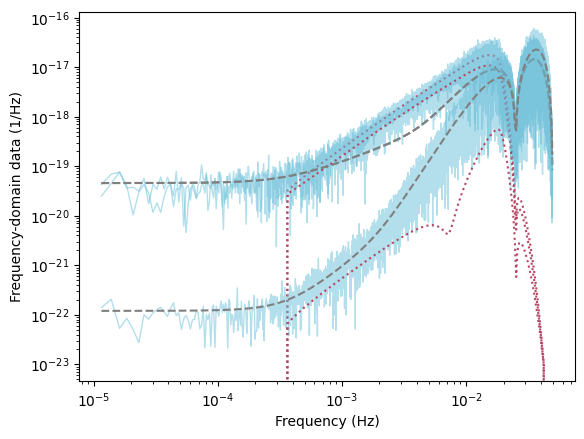

In [10]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## Rapid search phase 

### initialize $\mathcal{F}$-stat and likelihood

In [11]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True 
)

Like = Likelihood(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True,
)

number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}
number of freuqncies: 21077
min and max frequencies: 1.1574074074074073e-05 0.04939814814814815
response kwargs: {'modes': [(2, 2)], 'tmin': 10.0, 'tmax': 15.0, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False, 'interpolation': True}


### compare $\mathcal{F}$-stat and likelihood around truths

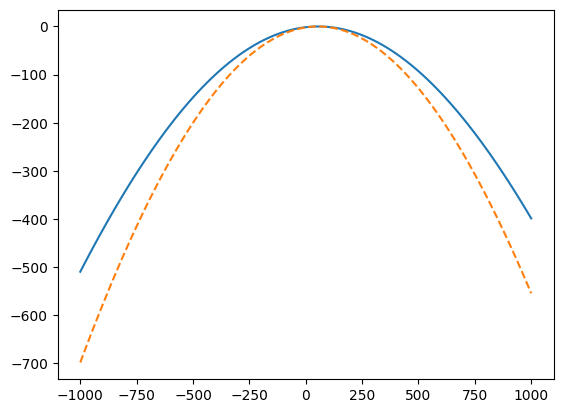

In [12]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["chirp_mass"] = mbhb_parameters["chirp_mass"] + np.linspace(-1000, 1000, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["chirp_mass"] = test_int_params["chirp_mass"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_F - np.max(test_F))
plt.plot(test_int_params["chirp_mass"] - mbhb_parameters["chirp_mass"], test_L - np.max(test_L), linestyle="--")

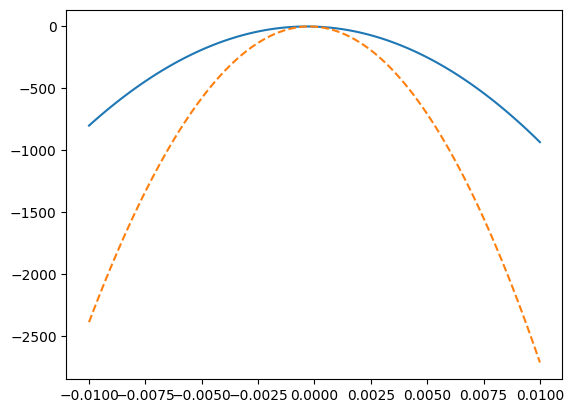

In [13]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["spin_1z"] = mbhb_parameters["spin_1z"] + np.linspace(-0.01, 0.01, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["spin_1z"] = test_int_params["spin_1z"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_F - np.max(test_F))
plt.plot(test_int_params["spin_1z"] - mbhb_parameters["spin_1z"], test_L - np.max(test_L), linestyle="--")

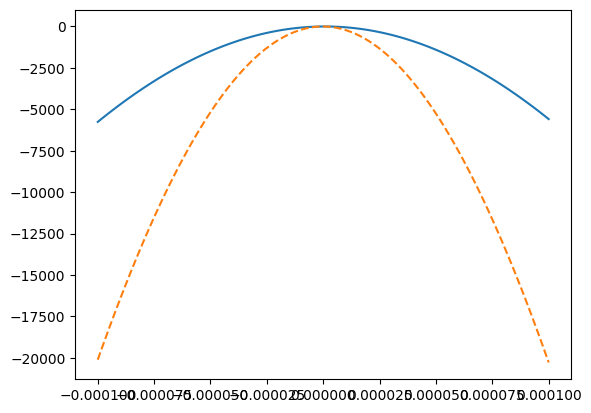

In [14]:
Ntest = 101

test_int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    test_int_params.pop(key)
for k, v in test_int_params.items():
    test_int_params[k] = np.ones(Ntest) * v 
test_int_params["coalescence_time"] = mbhb_parameters["coalescence_time"] + np.linspace(-1e-4, 1e-4, Ntest)
test_F = Fstat.calculate_Fstat_vectorized(test_int_params)

test_params = copy.deepcopy(mbhb_parameters)
for k, v in test_params.items():
    test_params[k] = np.ones(Ntest) * v 
test_params["coalescence_time"] = test_int_params["coalescence_time"].copy() 
test_L = Like.full_log_like_vectorized(ParamDict2ParamArr(test_params))

plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_F - np.max(test_F))
plt.plot(test_int_params["coalescence_time"] - mbhb_parameters["coalescence_time"], test_L - np.max(test_L), linestyle="--")

### test waveform and parameter recovery

In [15]:
int_params = copy.deepcopy(mbhb_parameters)
for key in Fstatistics.extrinsic_parameter_names:
    int_params.pop(key)
int_params

{'chirp_mass': 438193.2644572536,
 'mass_ratio': 0.3943544732088221,
 'spin_1z': 0.8963384117823039,
 'spin_2z': -0.6096475254341194,
 'coalescence_time': 14.610477193572,
 'longitude': 2.779190495557772,
 'latitude': -0.03194311323884908}

In [16]:
rec_wave = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)
rec_wave.shape

(3, 1, 21077)

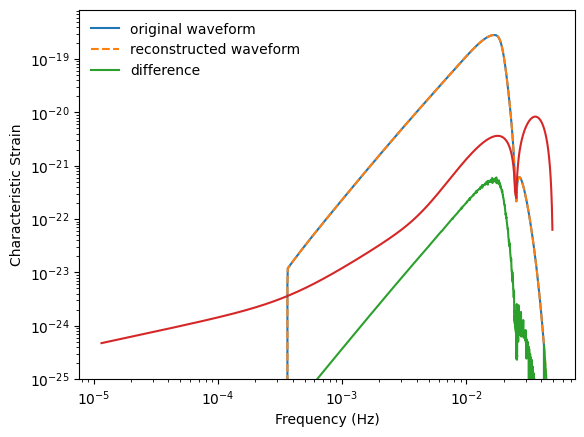

In [17]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave[0][0].get() - wf_channels[0].get()) * data_frequencies, label="difference")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

In [18]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
rec_a.shape 

(1, 4)

In [19]:
rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)
for k, v in rec_ext_params.items():
    if k in ["coalescence_phase", "psi"]:
        print(k, 2.*v, 2.*mbhb_parameters[k])
    else:
        print(k, v, mbhb_parameters[k])

luminosity_distance 52230.39784142599 52284.764366410825
inclination 1.3068379059221689 1.306062455447996
psi 5.852103341478837 5.847227170351766
coalescence_phase 1.1832428864046347 4.323599945201539


### optimization from prior 

In [20]:
intrinsic_parameter_ranges = np.array([
    [5.5, 6.5], 
    [0.1, 1.], 
    [-0.99, 0.99], 
    [-0.99, 0.99], 
    # [mbhb_parameters["coalescence_time"]-0.01, mbhb_parameters["coalescence_time"]+0.01], 
    [t_start / DAY + 3., t_end / DAY], 
    [0, TWOPI], 
    [-1., 1.]
])

intrinsic_parameter_ranges

array([[ 5.5       ,  6.5       ],
       [ 0.1       ,  1.        ],
       [-0.99      ,  0.99      ],
       [-0.99      ,  0.99      ],
       [13.        , 15.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ]])

In [21]:
from scipy.optimize import differential_evolution

n_dim_int = len(Fstatistics.intrinsic_parameter_names)
print("number of parameters to be optimized:", n_dim_int)

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=False,
    vectorized=True,
)
print(DE_result)

number of parameters to be optimized: 7


/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -95596.52898400926
                   x: [ 1.418e-01  3.218e-01  9.597e-01  1.651e-01
                        8.050e-01  4.538e-01  4.709e-01]
                 nit: 528
                nfev: 529
          population: [[ 1.418e-01  3.218e-01 ...  4.538e-01  4.709e-01]
                       [ 1.418e-01  3.217e-01 ...  4.539e-01  4.695e-01]
                       ...
                       [ 1.418e-01  3.219e-01 ...  4.541e-01  4.710e-01]
                       [ 1.418e-01  3.218e-01 ...  4.536e-01  4.710e-01]]
 population_energies: [-9.560e+04 -9.560e+04 ... -9.560e+04 -9.560e+04]


### reconstruct parameters and waveforms 

In [22]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_parameter_ranges[:, 1] - intrinsic_parameter_ranges[:, 0]) + intrinsic_parameter_ranges[:, 0])

searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

chirp_mass 438193.2644572536 139.61438785376959
mass_ratio 0.3943544732088221 0.004689788323705257
spin_1z 0.8963384117823039 0.01394240759232801
spin_2z -0.6096475254341194 0.0534068584923485
coalescence_time 14.610477193572 0.00038232997286336
longitude 2.779190495557772 0.07217210797479989
latitude -0.03194311323884908 0.026286192396416823
luminosity_distance 52284.764366410825 679.1433746597686
inclination 1.306062455447996 0.03926774607077821
psi 2.923613585175883 0.02918765237901466
coalescence_phase 2.1617999726007695 1.591265911186774


(3, 21077)

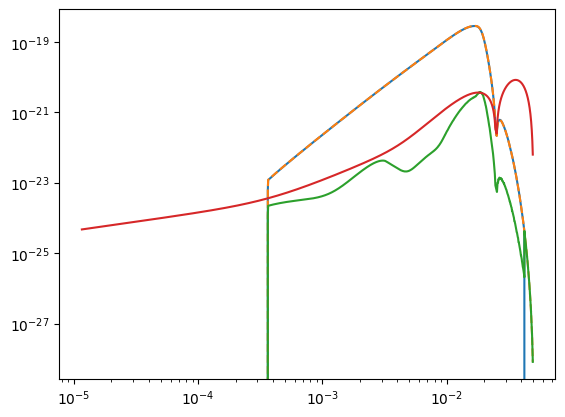

In [36]:
searched_wf = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)[:, 0, :]

# searched_wf = FDTDI_GPU.Response(
#     searched_params, 
#     data_frequencies_GPU, 
#     **response_kwargs_GPU, 
# )

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies)
plt.loglog(data_frequencies, np.abs(searched_wf[0].get()) * data_frequencies, linestyle="--")
plt.loglog(data_frequencies, np.abs(searched_wf[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies))

searched_wf.shape 

## Fisher analysis 

In [24]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.001,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=1,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

11 parameters in total: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'longitude', 'latitude', 'luminosity_distance', 'inclination', 'psi', 'coalescence_phase']
11 analyzed parameters: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']
parameters whose steps should be tested: ['chirp_mass', 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time', 'coalescence_phase', 'luminosity_distance', 'inclination', 'longitude', 'latitude', 'psi']

 ========= testing parameter chirp_mass ==========
error = 5.241529285167045
shift = 5.0 relative diff = 3.086132006678144e-06
shift of parameter chirp_mass is 5.0

 ========= testing parameter mass_ratio ==========
error = 0.018831236150564697
shift = 0.005 relative diff = 0.0003374489756152541
error = 0.018843359701648976
shift = 0.0025 relative diff = 0.0005380597048807298
error = 0.01885089738084709
shift = 0.00125 r

In [25]:
FIM.param_errors

{'chirp_mass': 124.67361289035242,
 'mass_ratio': 0.0057609041186695124,
 'spin_1z': 0.012980512706939383,
 'spin_2z': 0.051946785424687884,
 'coalescence_time': 0.00021932232356257448,
 'coalescence_phase': 0.05412113668965543,
 'luminosity_distance': 6678.825832789252,
 'inclination': 0.05554814197200918,
 'longitude': 0.038558743420966365,
 'latitude': 0.08016941638921905,
 'psi': 0.11727515178901388}

## The 1st heterodyned search 

In [26]:
Like.prepare_het_log_like(
    base_parameters=ParamDict2ParamArr(searched_params), 
    # base_waveform=searched_wf[:, 0, :]
    ) 

In [27]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [28]:
truths = np.array(ParamDict2ParamArr(searched_params)) # actually the searched values 
ground_truths = np.array(ParamDict2ParamArr(mbhb_parameters))
labels = np.array(list(mbhb_parameters.keys()))
fim_range = []
for par in labels:
    if par in ["chirp_mass", "luminosity_distance"]:
        ran = FIM.param_errors[par] / searched_params[par] # log value 
    else:
        ran = FIM.param_errors[par] # we donot process the sin/cos values since they will not be used 
    fim_range.append(ran)
fim_range = np.array(fim_range) * 10. # ~10 sigmas

for idx, par in enumerate(labels):
    print(par, truths[idx], fim_range[idx])

chirp_mass 5.641804047805359 0.002844267881953889
mass_ratio 0.38966468488511685 0.057609041186695124
spin_1z 0.9102808193746319 0.12980512706939384
spin_2z -0.6630543839264679 0.5194678542468788
coalescence_time 14.610094863599137 0.002193223235625745
coalescence_phase 0.5705340614139957 0.5412113668965544
luminosity_distance 4.723980020385094 1.2610145507843995
inclination 0.2993407215225536 0.5554814197200918
longitude 2.851362603532572 0.3855874342096637
latitude -0.0581964053278301 0.8016941638921905
psi 2.894425932796868 1.1727515178901387


In [29]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 400 # number of random walkers, more walkers can be used since heterodyned likelihood requires much less vRAM, 400 is a quite large number for this task 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set a narrower prior for the instrinsic parameters, since heterodyned likelihood must be based on an initial estimation 
lim_lgMc = [truths[0] - fim_range[0], truths[0] + fim_range[0]]
lim_q = [max(0.1, truths[1] - fim_range[1]), min(1., truths[1] + fim_range[1])]
lim_chiz1 = [max(-0.99, truths[2] - fim_range[2]), min(0.99, truths[2] + fim_range[2])]
lim_chiz2 = [max(-0.99, truths[3] - fim_range[3]), min(0.99, truths[3] + fim_range[3])]
# lim_tc = [truths[4] - fim_range[4], truths[4] + fim_range[4]] 
lim_tc = [truths[4] - 0.01 * searched_params["chirp_mass"] / 1e6, truths[4] + 0.01 * searched_params["chirp_mass"] / 1e6] # empirical 
lim_phic = [0, TWOPI]
lim_lgD = [max(4., truths[6]-fim_range[6]), min(5., truths[6]+fim_range[6])]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
# start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_lims = lims.copy()
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 5.63895978,  5.64464832],
        [ 0.33205564,  0.44727373],
        [ 0.78047569,  0.99      ],
        [-0.99      , -0.14358653],
        [14.60571153, 14.61447819],
        [ 0.        ,  6.28318531],
        [ 4.        ,  5.        ],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]),
 array([[ 5.63895978,  5.64464832],
        [ 0.33205564,  0.44727373],
        [ 0.78047569,  0.99      ],
        [-0.99      , -0.14358653],
        [14.60571153, 14.61447819],
        [ 0.        ,  6.28318531],
        [ 4.        ,  5.        ],
        [-1.        ,  1.        ],
        [ 0.        ,  6.28318531],
        [-1.        ,  1.        ],
        [ 0.        ,  3.14159265]]))

In [30]:
((lims.T - ground_truths)[0] < 0.).all(), ((lims.T - ground_truths)[1] > 0.).all()

(True, True)

In [31]:
lims.T - ground_truths

array([[-2.70591774e-03, -6.22988295e-02, -1.15862719e-01,
        -3.80352475e-01, -4.76565876e-03, -2.16179997e+00,
        -7.18375155e-01, -1.26165242e+00, -2.77919050e+00,
        -9.68062319e-01, -2.92361359e+00],
       [ 2.98261803e-03,  5.29192529e-02,  9.36615882e-02,
         4.66060996e-01,  4.00099882e-03,  4.12138533e+00,
         2.81624845e-01,  7.38347580e-01,  3.50399481e+00,
         1.03193768e+00,  2.17979068e-01]])

In [32]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    # return Like.full_log_like_vectorized(np.transpose(params))
    return Like.het_log_like_vectorized(np.transpose(params))

In [33]:
ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
)

In [34]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 400, 11)


  0%|          | 220/100000 [01:24<11:02:16,  2.51it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_25177/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 324, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/home

eryn: Exception while calling your likelihood function:
  args added: [array([[ 5.64187543,  0.40930771,  0.88361861, ...,  2.80387503,
         0.05838974,  1.45849512],
       [ 5.64156987,  0.39233868,  0.89338038, ...,  2.78812434,
         0.02856768,  1.42174617],
       [ 5.64175194,  0.39517403,  0.89719999, ...,  2.83493663,
         0.01021386,  1.40941655],
       ...,
       [ 5.64398236,  0.3519796 ,  0.86284427, ...,  2.20670554,
        -0.44016899,  1.09543626],
       [ 5.64223271,  0.38898214,  0.94977993, ...,  0.65686234,
        -0.40496087,  0.53337623],
       [ 5.64042635,  0.37885985,  0.84448661, ...,  3.45104615,
        -0.12152431,  2.20952824]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(150000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

 13%|█▎        | 19921/150000 [1:49:42<11:46:26,  3.07it/s]Traceback (most recent call last):
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/eryn/ensemble.py", line 1644, in __call__
    out = self.f(*args_in, **kwargs_in)
  File "/tmp/ipykernel_20330/3626440450.py", line 4, in eryn_like
    return Like.het_log_like_vectorized(np.transpose(params))
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Utils.py", line 324, in het_log_like_vectorized
    het_h = self.xp.transpose(self.response_generator.Response(
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 1093, in Response
    _, GTDI = self.TransferFunction(t=tgrids[mode], f=fgrids, k=k, Plm=Plm[mode], TDIGeneration=TDIGeneration, tmin=tmin, tmax=tmax)
  File "/home/ps/miniconda3/envs/tri_env/lib/python3.9/site-packages/Triangle_BBH/Response.py", line 964, in TransferFunction
    zero_inds = self.xp.where(t < tmin * DAY)
  File "/

eryn: Exception while calling your likelihood function:
  args added: [array([[ 6.06085751,  0.2541853 ,  0.36596539, ...,  3.15470111,
        -0.27247159,  0.68285522],
       [ 6.06065558,  0.25363127,  0.3678356 , ...,  3.15218458,
        -0.26238568,  0.48036772],
       [ 6.06036007,  0.25481495,  0.35583669, ...,  3.17614592,
        -0.24034097,  1.96595959],
       ...,
       [ 6.05906473,  0.26173246,  0.42527901, ...,  1.70045314,
         0.57883293,  1.40001287],
       [ 6.05912258,  0.24741675,  0.43833501, ...,  1.67216363,
         0.18573292,  3.06401209],
       [ 6.05935039,  0.25699743,  0.42237182, ...,  5.30854478,
        -0.0588558 ,  1.64454713]])]
  args: []
  kwargs added: {}
  kwargs: {}
  exception:


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

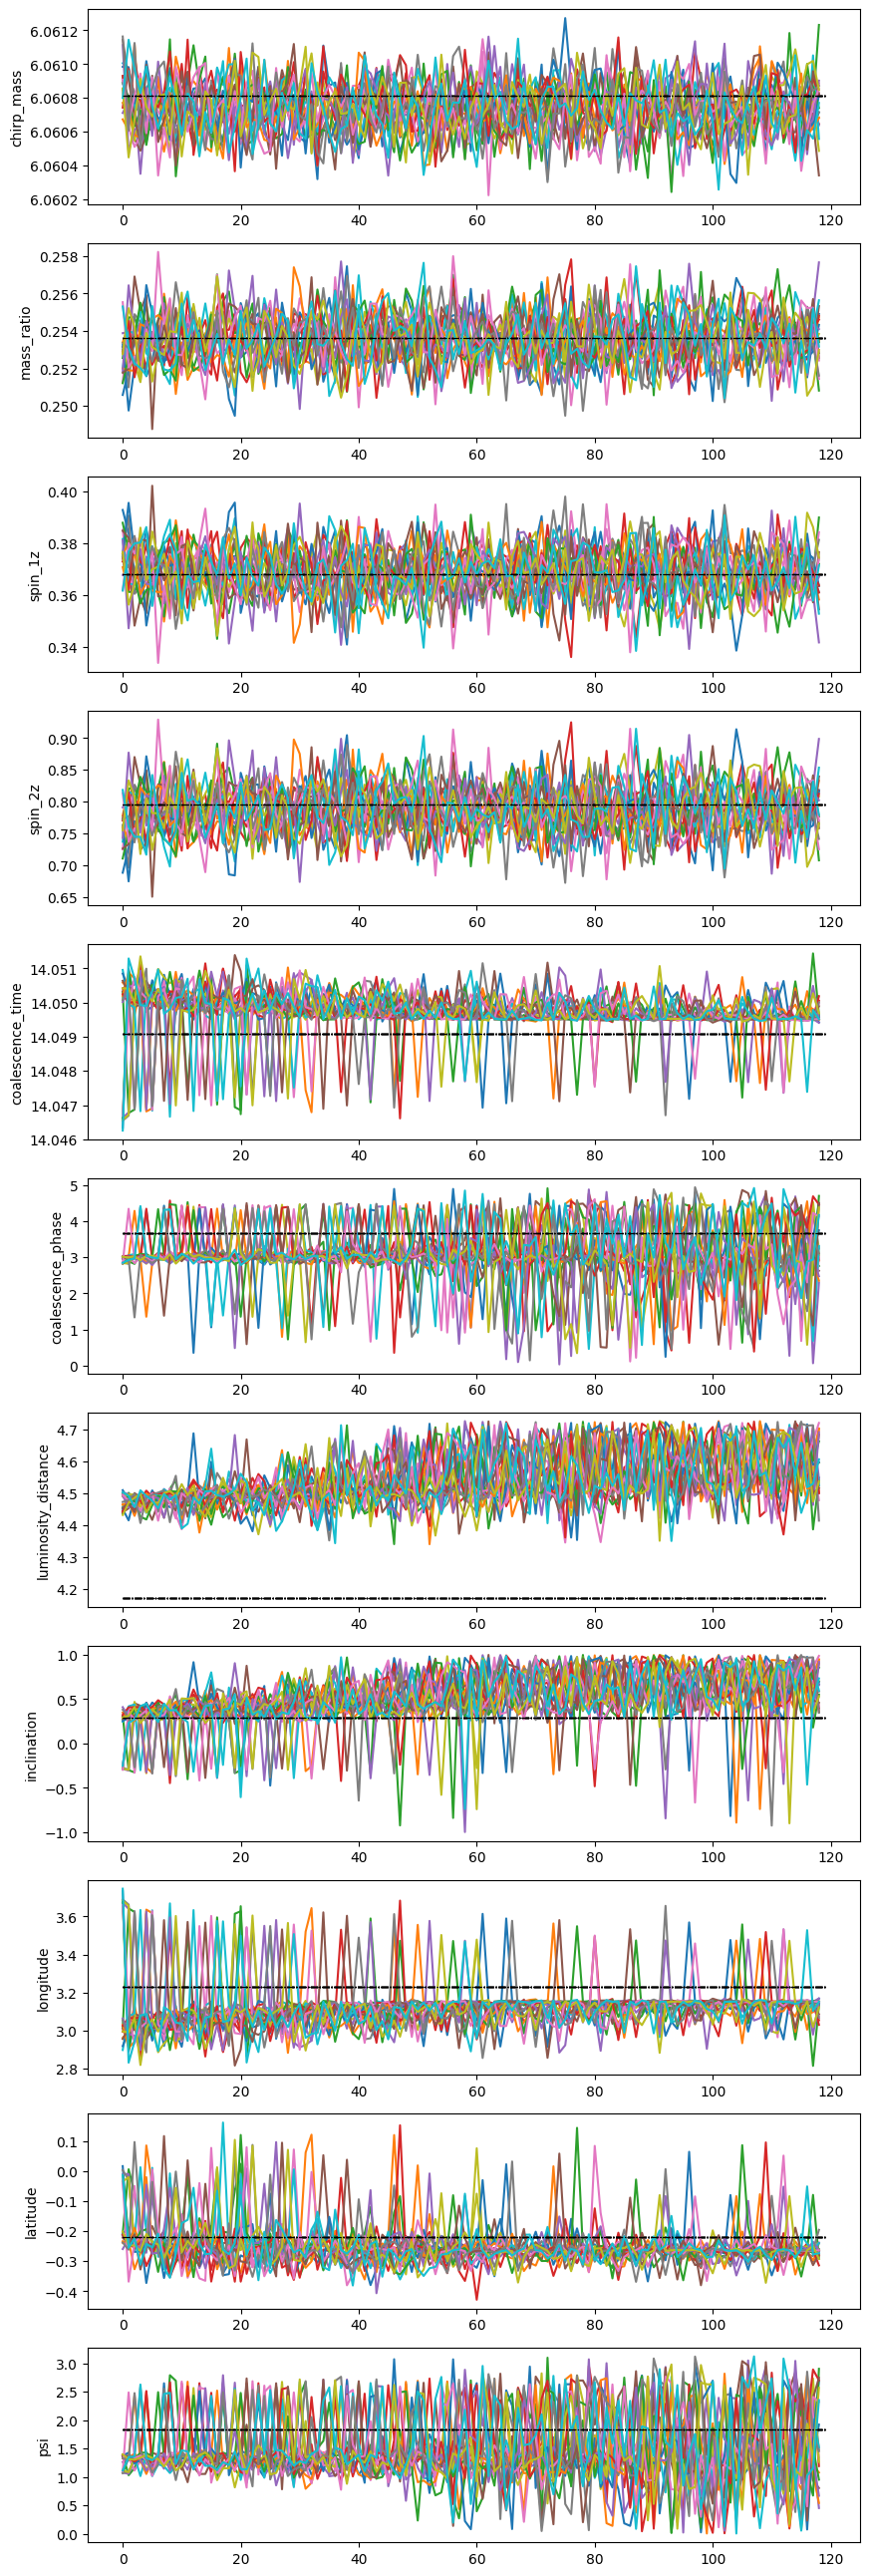

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(ground_truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_het.jpg", dpi=360)

sample shape: (39600, 11)


<Figure size 640x480 with 0 Axes>

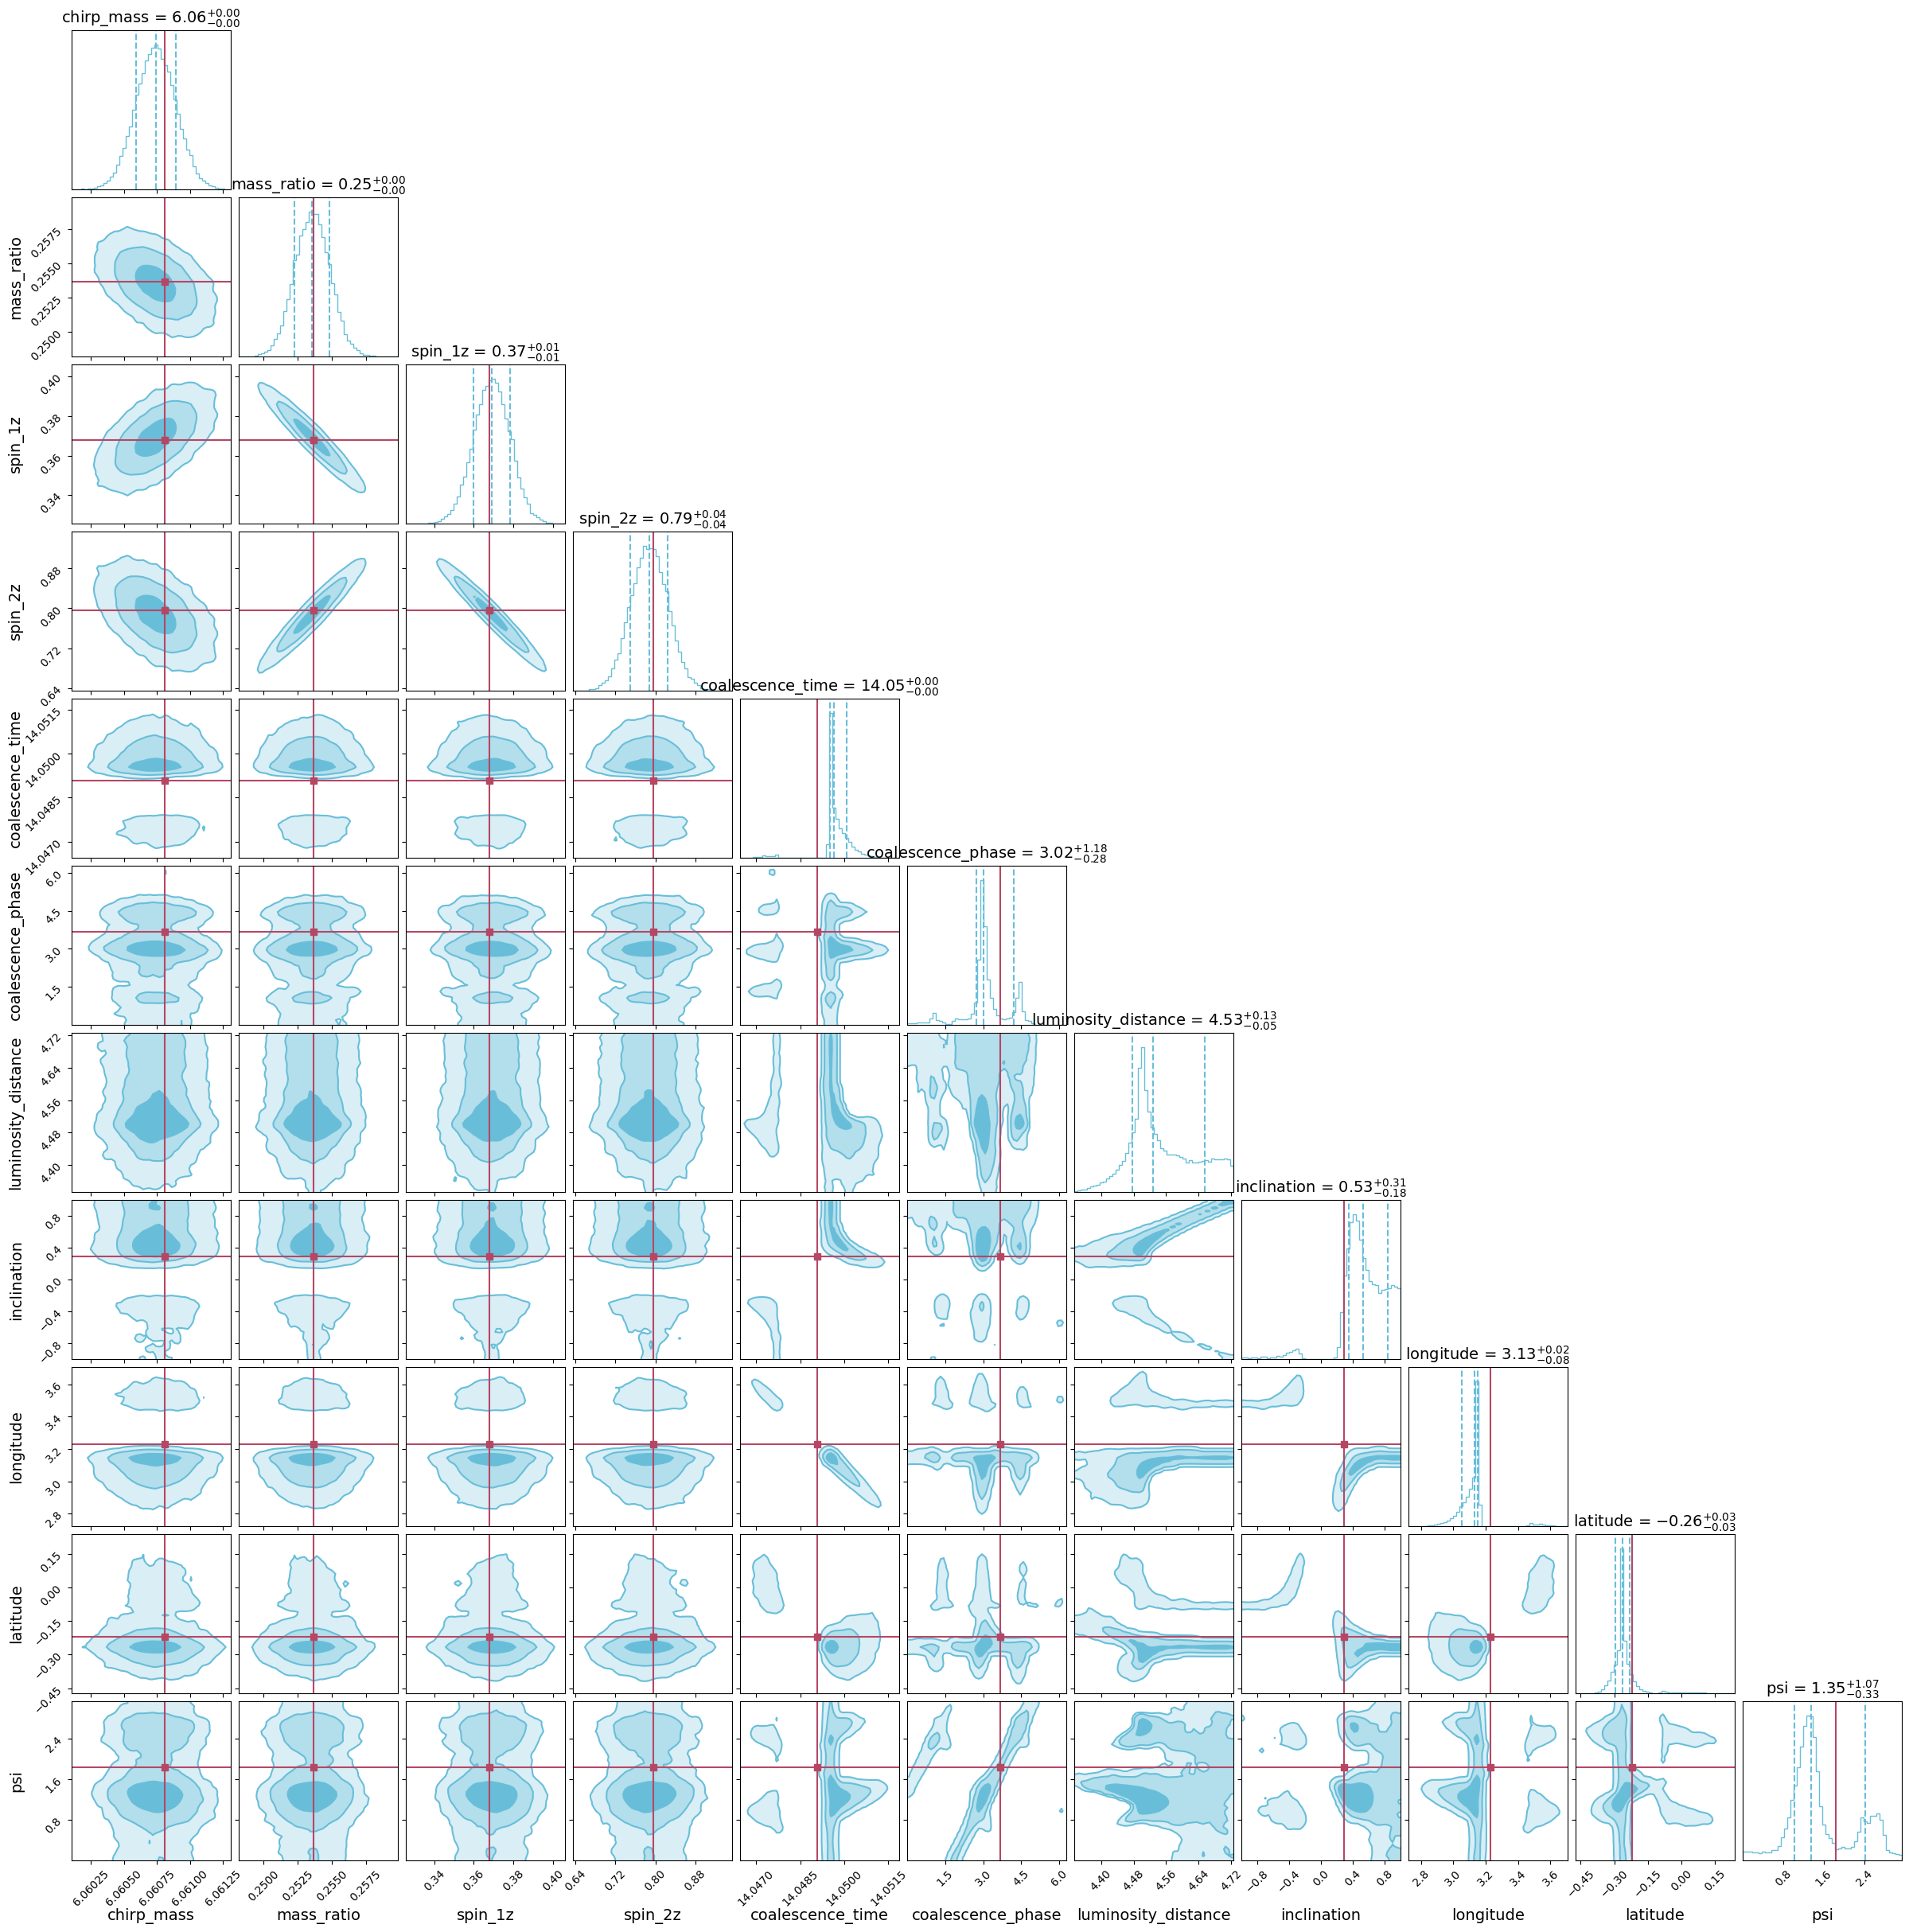

In [ ]:
burnin=200
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=ground_truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_het.jpg", dpi=360)
# np.save("chain_het.npy", samp)

In [ ]:
truths - ground_truths

array([-5.44836240e-06, -5.77726615e-05,  1.40369313e-03, -8.26486765e-03,
       -1.75234644e-03, -3.84181293e+00,  3.11768544e-01, -6.30611058e-01,
        3.09964724e-01,  2.50215666e-01, -2.54684751e+00])

In [ ]:
ground_truths

array([ 6.06081086,  0.25364638,  0.36789836,  0.7958377 , 14.04907261,
        3.66372009,  4.17163975,  0.28642366,  3.23109711, -0.21939293,
        1.83877349])